Running experiment for epsilon = 0.0...
Running experiment for epsilon = 0.1...
Running experiment for epsilon = 0.01...


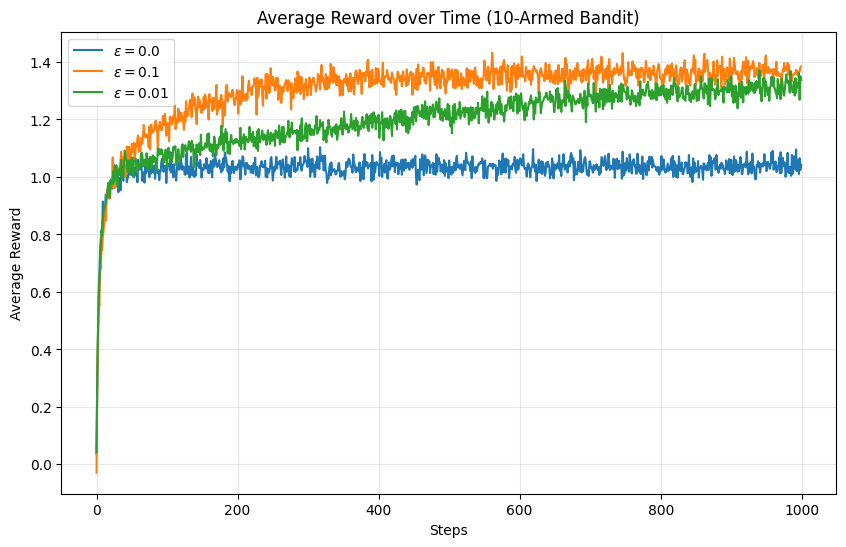

Running experiment for Optimistic Initialization...


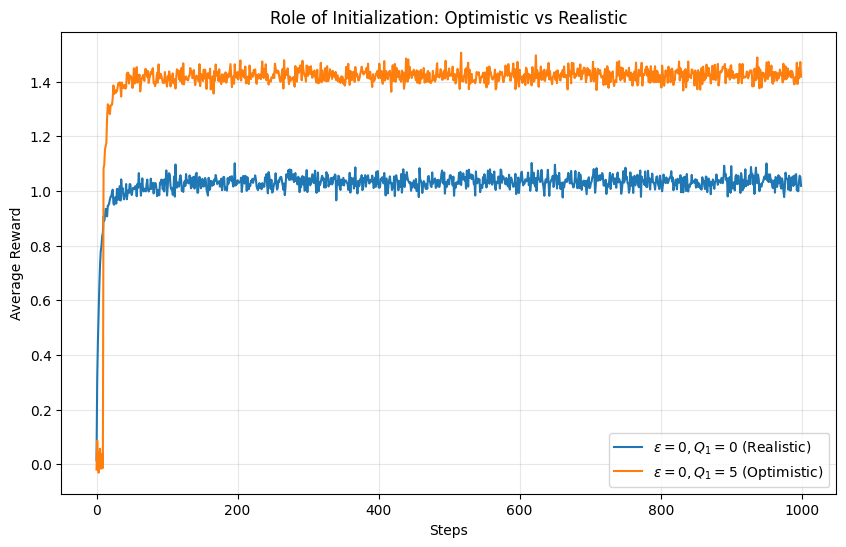

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class BanditProblem:
    def __init__(self, k=10, mean=0, std=1):
        """
        Initialize the k-armed bandit.
        m_i (true_values) are selected from a distribution (e.g., N(0,1)).
        """
        self.k = k
        # m_i: True mean values for each action, sampled from N(0,1)
        # as per instructions to choose a distribution 
        self.true_values = np.random.normal(mean, std, k)
        
        # Optimal action is the one with the highest true mean
        self.optimal_action = np.argmax(self.true_values)

    def step(self, action):
        """
        Takes an action and returns a reward.
        R(A_i) = m_i + w, where w ~ N(0,1) 
        """
        # Mean for the chosen action
        mean = self.true_values[action]
        # Reward is mean + noise
        reward = np.random.normal(mean, 1)
        return reward

def run_experiment(epsilon, steps=1000, runs=2000, initial_q=0.0):
    """
    Runs the bandit experiment multiple times to average out noise.
    
    Args:
        epsilon: Probability of exploring.
        steps: Number of time steps per run.
        runs: Number of independent experiments to average.
        initial_q: Initial estimate for Q values (Role of Initialization).
    """
    # Arrays to store average rewards and optimal action % at each step
    avg_rewards = np.zeros(steps)
    
    for r in range(runs):
        # Create a new bandit problem for each run
        bandit = BanditProblem()
        
        # Initialize Q-values (estimates) and Action counts (N)
        q_values = np.full(bandit.k, initial_q)
        action_counts = np.zeros(bandit.k)
        
        for t in range(steps):
            # Epsilon-greedy policy implementation 
            if np.random.rand() < epsilon:
                # Explore: Random action
                action = np.random.randint(bandit.k)
            else:
                # Exploit: Greedy action (breaking ties randomly)
                # Note: standard np.argmax always picks the first index in a tie,
                # so we add small noise or shuffle to break ties fairly.
                action = np.random.choice(np.flatnonzero(q_values == q_values.max()))
            
            # Get reward from environment
            reward = bandit.step(action)
            
            # Update counts
            action_counts[action] += 1
            
            # Update Q-value estimates using incremental average:
            # Q_new = Q_old + (1/N) * (Reward - Q_old)
            q_values[action] += (1.0 / action_counts[action]) * (reward - q_values[action])
            
            # Record reward for this step
            avg_rewards[t] += reward

    # Average over all runs
    avg_rewards /= runs
    return avg_rewards

# --- Parameters ---
steps = 1000
runs = 2000  # Higher runs = smoother plots
epsilons = [0.0, 0.1, 0.01]

# --- Experiment 1: Effect of Epsilon ---
plt.figure(figsize=(10, 6))

for eps in epsilons:
    print(f"Running experiment for epsilon = {eps}...")
    rewards = run_experiment(epsilon=eps, steps=steps, runs=runs, initial_q=0.0)
    plt.plot(rewards, label=f'$\epsilon = {eps}$')

plt.title('Average Reward over Time (10-Armed Bandit)')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Experiment 2: Role of Initialization  ---
# Comparing Optimistic Initialization (Q=5) vs Realistic (Q=0)
print("Running experiment for Optimistic Initialization...")
greedy_realistic = run_experiment(epsilon=0.0, steps=steps, runs=runs, initial_q=0.0)
greedy_optimistic = run_experiment(epsilon=0.0, steps=steps, runs=runs, initial_q=5.0)

plt.figure(figsize=(10, 6))
plt.plot(greedy_realistic, label='$\epsilon=0, Q_1=0$ (Realistic)')
plt.plot(greedy_optimistic, label='$\epsilon=0, Q_1=5$ (Optimistic)')
plt.title('Role of Initialization: Optimistic vs Realistic')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training Q-learning agent...

Results:
State  | Reward   | Best Action  | Value (V) 
--------------------------------------------------
1      | 5        | <-           | 50.0000
2      | 4        | <-           | 49.0801
3      | 3        | <-           | 46.4174
4      | 2        | <-           | 43.2464
5      | 1        | ->           | 40.2636
6      | 2        | ->           | 47.2608
7      | 3        | ->           | 52.9418
8      | 5        | ->           | 54.8102
9      | 6        | <-           | 54.7672
10     | 3        | <-           | 52.3584


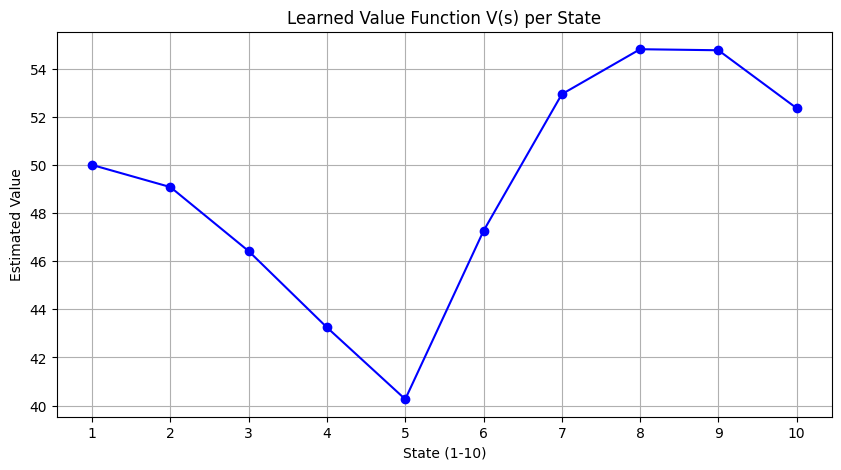

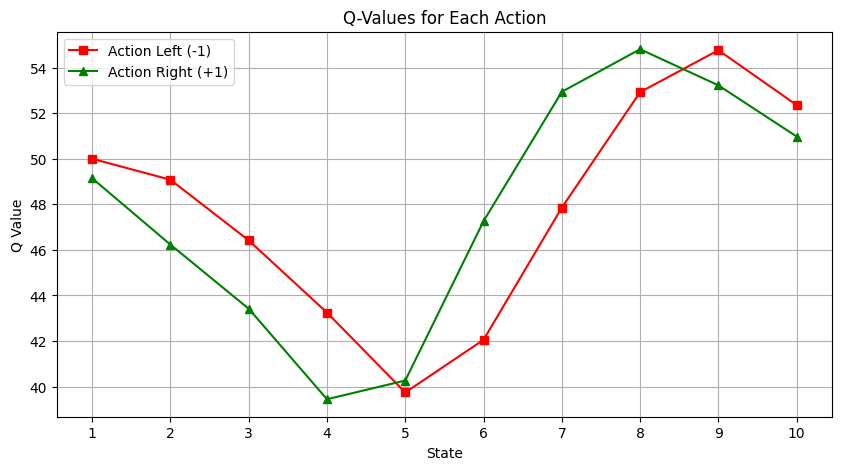

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the Environment ---
class RandomWalkEnv:
    def __init__(self):
        # States 1 through 10 (mapped to indices 0 through 9)
        self.n_states = 10
        # Actions: 0 -> Move Left (-1), 1 -> Move Right (+1)
        self.actions = [0, 1] 
        self.state = 0 # Start at state 1 (index 0)

        # Reward table based on the assignment description 
        # s: 1  2  3  4  5  6  7  8  9  10
        # r: 5  4  3  2  1  2  3  5  6  3
        self.rewards = np.array([5, 4, 3, 2, 1, 2, 3, 5, 6, 3])

    def reset(self):
        """Reset to a random state or state 1."""
        self.state = np.random.randint(0, self.n_states)
        return self.state

    def step(self, action_idx):
        """
        Executes action and returns (next_state, reward).
        Action 0 (-1): Left, Action 1 (+1): Right.
        Dynamics: 50% move, 50% stay[cite: 21, 22].
        """
        current_s = self.state
        
        # Determine intended direction
        direction = -1 if action_idx == 0 else 1
        
        # Stochastic dynamics: 50% chance to move, 50% chance to stay
        if np.random.rand() < 0.5:
            next_s = current_s + direction
        else:
            next_s = current_s

        # Apply Boundaries (Clip to 0..9)
        # If moving left from 1, stay at 1. If moving right from 10, stay at 10.
        next_s = np.clip(next_s, 0, self.n_states - 1)
        
        # Update state
        self.state = next_s
        
        # Return observation and reward
        # Reward depends on the state (r(s)) 
        # Note: The prompt implies r(s_t, a_t) depends on state. 
        # Usually rewards are given for entering or being in a state.
        # We assume the reward is received for the *current* state.
        reward = self.rewards[self.state]
        
        return next_s, reward

# --- 2. Q-Learning Algorithm ---
def q_learning(episodes=2000, alpha=0.1, gamma=0.9, epsilon=0.1):
    env = RandomWalkEnv()
    
    # Initialize Q-table: [States x Actions] -> [10 x 2]
    # actions: 0=Left, 1=Right
    Q = np.zeros((env.n_states, 2))
    
    for ep in range(episodes):
        state = env.reset()
        done = False
        steps = 0
        
        # Since this is an infinite horizon problem, 
        # we treat it as continuous but cut off episodes for training loops.
        max_steps_per_episode = 100
        
        while steps < max_steps_per_episode:
            # Epsilon-Greedy Policy
            if np.random.rand() < epsilon:
                action = np.random.choice(env.actions)
            else:
                # Break ties randomly
                best_actions = np.flatnonzero(Q[state] == Q[state].max())
                action = np.random.choice(best_actions)
            
            # Interact with environment
            next_state, reward = env.step(action)
            
            # Q-Learning Update Rule [cite: 27]
            # Q(s,a) = Q(s,a) + alpha * [r + gamma * max(Q(s',a')) - Q(s,a)]
            best_next_q = np.max(Q[next_state])
            td_target = reward + gamma * best_next_q
            td_error = td_target - Q[state, action]
            
            Q[state, action] += alpha * td_error
            
            state = next_state
            steps += 1
            
    return Q

# --- 3. Execution and Visualization ---

# Run Q-learning
print("Training Q-learning agent...")
trained_Q = q_learning(episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.1)

# Extract optimal policy and value function
optimal_policy_idx = np.argmax(trained_Q, axis=1)
value_function = np.max(trained_Q, axis=1)

# Mapping for display
policy_arrows = ['<-' if x == 0 else '->' for x in optimal_policy_idx]
states = np.arange(1, 11)

print("\nResults:")
print(f"{'State':<6} | {'Reward':<8} | {'Best Action':<12} | {'Value (V)':<10}")
print("-" * 50)
for i in range(10):
    print(f"{states[i]:<6} | {RandomWalkEnv().rewards[i]:<8} | {policy_arrows[i]:<12} | {value_function[i]:.4f}")

# Plotting the Value Function
plt.figure(figsize=(10, 5))
plt.plot(states, value_function, marker='o', linestyle='-', color='b')
plt.title('Learned Value Function V(s) per State')
plt.xlabel('State (1-10)')
plt.ylabel('Estimated Value')
plt.xticks(states)
plt.grid(True)
plt.show()

# Plotting the Q-values
plt.figure(figsize=(10, 5))
plt.plot(states, trained_Q[:, 0], marker='s', label='Action Left (-1)', color='r')
plt.plot(states, trained_Q[:, 1], marker='^', label='Action Right (+1)', color='g')
plt.title('Q-Values for Each Action')
plt.xlabel('State')
plt.ylabel('Q Value   raise AttributeError(f"module '{__name__}' has no attribute '{name}'")
AttributeError: module 'torch' has no attribute 'randn_as'')
plt.xticks(states)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# --- Configuration ---
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005              # Target network update rate (soft update)
LR = 1e-4
USE_DOUBLE_DQN = True    # Set to False for standard DQN
CUSTOM_REWARD = True     # Set to True to use the 1 - 5*theta^2 reward

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Custom Reward Wrapper ---
class CustomRewardWrapper(gym.Wrapper):
    """
    Modifies the reward to r = 1 - 5 * theta^2 for non-terminal states.
    Original CartPole reward is +1.0 for every step taken.
    """
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        if not (terminated or truncated) and CUSTOM_REWARD:
            # Observation state: [x, x_dot, theta, theta_dot]
            theta = obs[2]
            # Proposed reward: 1 - 5 * theta^2
            # This penalizes deviation from vertical (0 rad).
            reward = 1.0 - 5.0 * (theta ** 2)
            
        return obs, reward, terminated, truncated, info

# --- 2. Neural Network ---
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# --- 3. Replay Memory ---
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- 4. Agent & Training Logic ---
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        if USE_DOUBLE_DQN:
            # Double DQN: 
            # Action selection: argmax_a Q_policy(s', a)
            # Evaluation: Q_target(s', action_selection)
            next_actions = policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
            next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions).squeeze()
        else:
            # Standard DQN:
            # max_a Q_target(s', a)
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# --- 5. Main Execution ---
def train_agent():
    # Setup Environment
    env = gym.make("CartPole-v1")
    if CUSTOM_REWARD:
        env = CustomRewardWrapper(env)
    
    n_actions = env.action_space.n
    state, _ = env.reset()
    n_observations = len(state)

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(10000)

    steps_done = 0
    episode_durations = []

    print(f"Starting Training (Double DQN: {USE_DOUBLE_DQN})...")
    
    num_episodes = 300 if torch.cuda.is_available() else 150 # Reduced for quick demo

    for i_episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        for t in count():
            # Select Action (Epsilon Greedy)
            sample = random.random()
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                math.exp(-1. * steps_done / EPS_DECAY)
            steps_done += 1
            
            if sample > eps_threshold:
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)
            else:
                action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

            # Step
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store in memory
            memory.push(state, action, next_state, reward)
            state = next_state

            # Perform optimization step
            optimize_model(memory, policy_net, target_net, optimizer)

            # Soft update of target network
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                break

        if (i_episode + 1) % 20 == 0:
            print(f"Episode {i_episode+1}/{num_episodes} completed. Last Duration: {t+1}")

    print("Training Complete")
    return policy_net

# --- 6. Visualization & Analysis ---

def plot_decision_boundary(policy_net):
    """
    Plots the decision surface for theta vs theta_dot (angle vs angular velocity).
    We hold x (position) and x_dot (velocity) constant at 0.
    """
    print("Generating decision boundary plot...")
    
    # Grid range
    theta_range = np.linspace(-0.25, 0.25, 100) # Roughly -15 to +15 degrees
    theta_dot_range = np.linspace(-2.0, 2.0, 100)
    
    grid_theta, grid_theta_dot = np.meshgrid(theta_range, theta_dot_range)
    actions = np.zeros_like(grid_theta)

    policy_net.eval()
    with torch.no_grad():
        for i in range(100):
            for j in range(100):
                # Construct state: [x=0, x_dot=0, theta, theta_dot]
                t = grid_theta[i, j]
                td = grid_theta_dot[i, j]
                state = torch.tensor([0.0, 0.0, t, td], dtype=torch.float32, device=device).unsqueeze(0)
                
                # Get action
                action = policy_net(state).max(1)[1].item()
                actions[i, j] = action

    plt.figure(figsize=(8, 6))
    # Countourf: 0 (Left) -> Blue, 1 (Right) -> Red
    plt.contourf(grid_theta, grid_theta_dot, actions, levels=[-0.5, 0.5, 1.5], alpha=0.6, colors=['blue', 'red'])
    plt.colorbar(ticks=[0, 1], label="Action (0: Left, 1: Right)")
    plt.title(f"Decision Boundary (Double DQN={USE_DOUBLE_DQN})")
    plt.xlabel("Theta (Angle)")
    plt.ylabel("Theta Dot (Angular Velocity)")
    plt.grid(True, alpha=0.3)
    
    # Empirical Linear Controller Line (Visual check)
    # A simple stabilizer often looks like theta + k * theta_dot = 0
    # Ideally, if falling right (theta > 0), we push right (Action 1) to catch it? 
    # Actually, if falling right, we must move right to put base under COM.
    plt.show()

if __name__ == "__main__":
    trained_model = train_agent()
    plot_decision_boundary(trained_model)
    
    # --- Empirical Linear Controller Check ---
    # The user asked: "Could you design a linear controller empirically?"
    # A simple PD controller for CartPole is: u = Kp * theta + Kd * theta_dot
    # Since u is binary (-1, 1), we use: Action = 1 if (theta + 0.1*theta_dot) > 0 else 0
    print("\nEmpirical Linear Controller Idea:")
    print("Action = 1 (Right) if (theta + k * theta_dot) > 0")
    print("This corresponds to a diagonal line passing through origin in the plot above.")